In [1]:
SMALL_SIZE, MEDIUM_SIZE = 9, 12
PROJECT_PATH = "/Users/donghur/Desktop/Research/Murthy/BM_GPU"
PROJECT_PATH_BMGPU = "/Users/donghur/Desktop/Research/Murthy/BM_GPU"

In [7]:
import sys
import pickle
import numpy as np
from glob import glob
import random, matplotlib
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

sys.path.append(PROJECT_PATH)
from utils.data import Dataset


In [3]:
import utils.figure as ufigure
%load_ext autoreload
%autoreload 1
%aimport utils.data
%aimport utils.figure

In [4]:
config_path = f"{PROJECT_PATH_BMGPU}/config_ant.yaml"
Data = Dataset(PROJECT_PATH, config_path)
Data.load_data()

  0%|          | 0/141 [00:00<?, ?it/s]

Loading config.yaml ...
Finished loading config
Loading INFO.yaml ...
Finished loading INFO


100%|██████████| 141/141 [00:25<00:00,  5.63it/s]


In [116]:
# configuration
INFO = Data.info
INFO_values = Data.info_values
config = Data.config
skeleton = config['skeleton']
skeleton_color= config['skeleton_color']

# features
bp = Data.data_obj['bodypoints']
rot_bp = Data.data_obj['rotated_bodypoints']
angles = Data.data_obj['angles']
limbs = Data.data_obj['limbs']
angle_power = Data.data_obj['angle_power']
limb_power = Data.data_obj['limb_power']

# embeddings
all_embed = Data.data_obj['all_embeddings']
all_postural_embed = Data.data_obj['all_postural_embeddings']
all_kinematic_embed = Data.data_obj['all_kinematic_embeddings']

In [48]:
with open (f"{PROJECT_PATH_BMGPU}/{config['result_path']}/angle_scale_model.pickle", 'rb') as file:
    angle_scaler = pickle.load(file)
with open (f"{PROJECT_PATH_BMGPU}/{config['result_path']}/limb_scale_model.pickle", 'rb') as file:
    limb_scaler = pickle.load(file)
    
scaled_angles = angle_scaler.transform(angles)
scaled_limbs = limb_scaler.transform(limbs)

/Users/donghur/anaconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.23.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


<hr><hr>

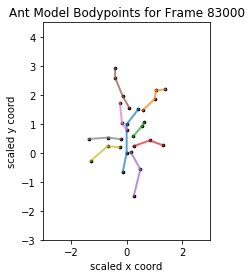

In [39]:
ufigure.ant_model(rot_bp,skeleton=skeleton, skeleton_color=skeleton_color,fr=83000,bounds=[-3,3,-3,4.5])

<hr><hr>

In [42]:
from helper import locate_bad_fr

INFO_items = list(INFO.items())

tot_good_fr = []
for key, file in tqdm(INFO_items):
    start_fr, stop_fr = file["global_start_fr"], file["global_stop_fr"]
    good_fr, bad_fr, disregard_fr = locate_bad_fr(config, rot_bp[start_fr:stop_fr])
    good_fr_global_idx = good_fr+start_fr
    tot_good_fr.append(good_fr_global_idx)
tot_good_fr=np.concatenate(tot_good_fr)

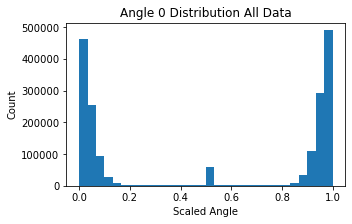

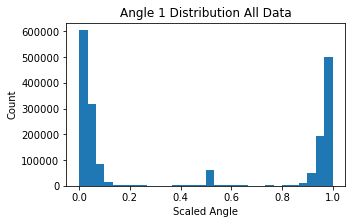

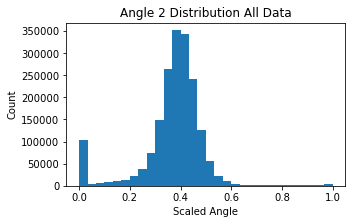

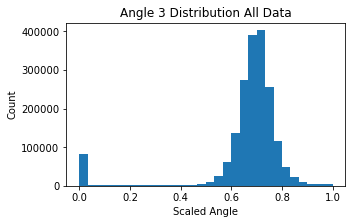

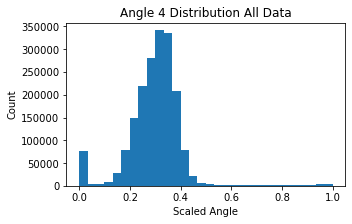

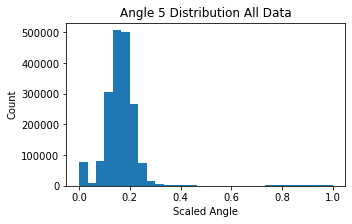

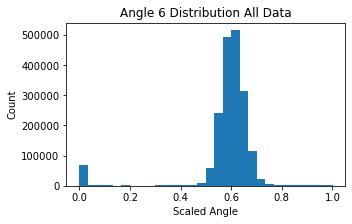

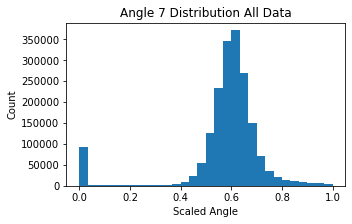

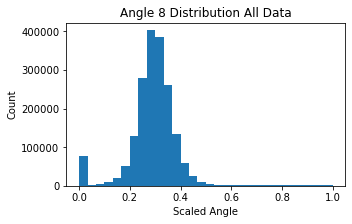

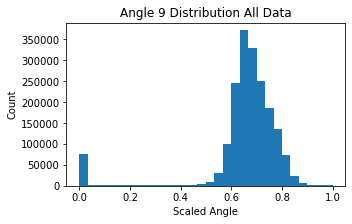

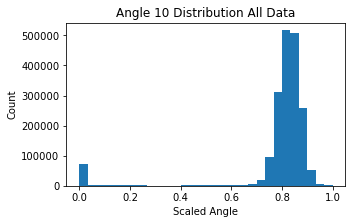

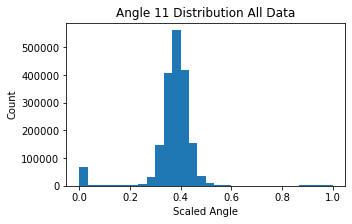

In [58]:
# Scaled Angles All Data
num_fr, num_angles = scaled_angles.shape
for i in range(num_angles):
    fig, ax = plt.subplots(figsize=(5,3))
    ax.hist(scaled_angles[:,i], bins=30)
    ax.set(xlabel="Scaled Angle", ylabel="Count", title=f"Angle {i} Distribution All Data")
    plt.show()

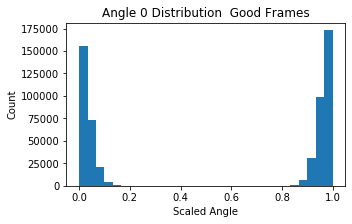

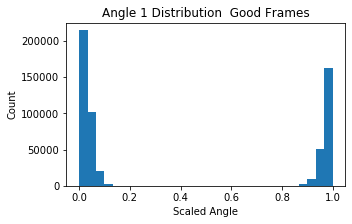

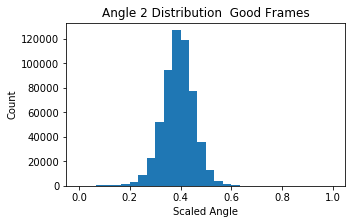

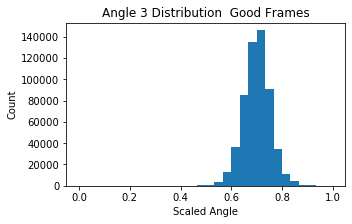

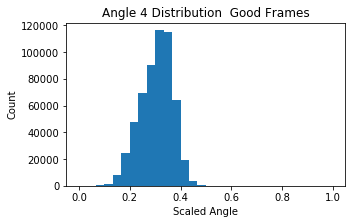

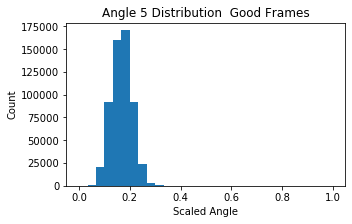

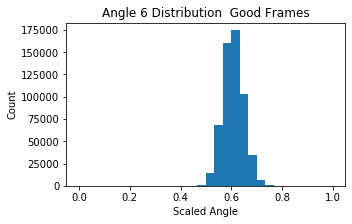

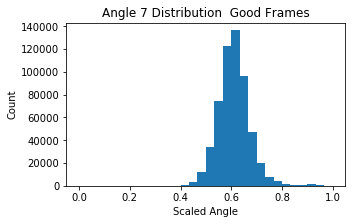

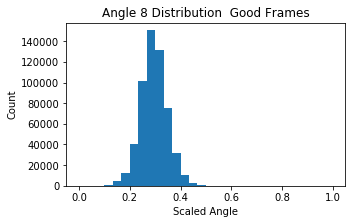

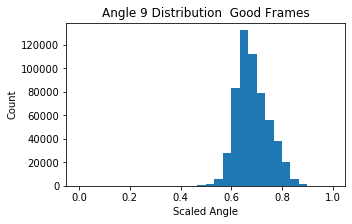

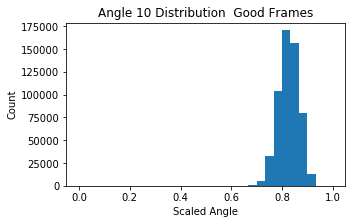

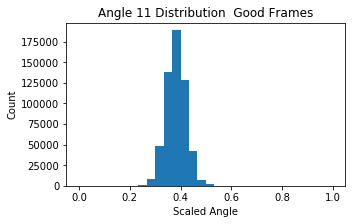

In [59]:
# Scaled Angles Good Data
num_fr, num_angles = scaled_angles.shape
for i in range(num_angles):
    fig, ax = plt.subplots(figsize=(5,3))
    ax.hist(scaled_angles[tot_good_fr,i], bins=30)
    ax.set(xlabel="Scaled Angle", ylabel="Count", title=f"Angle {i} Distribution  Good Frames")
    plt.show()

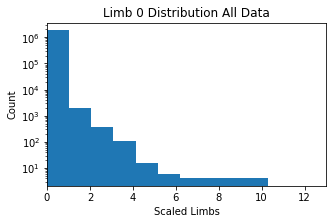

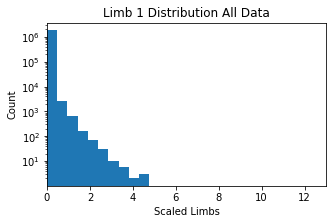

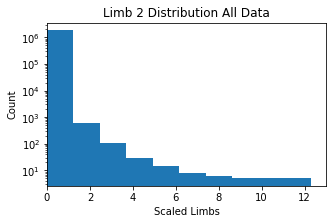

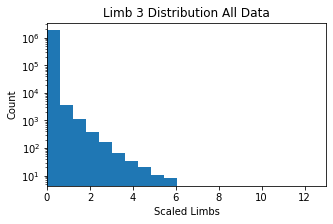

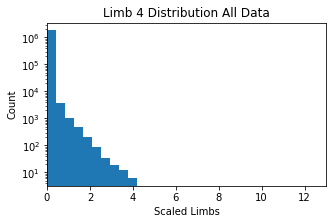

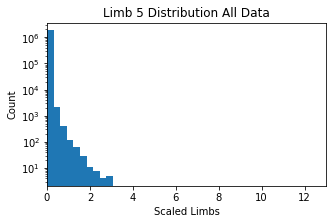

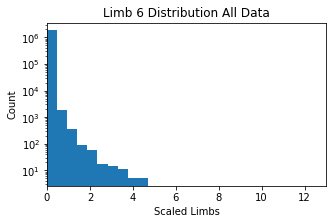

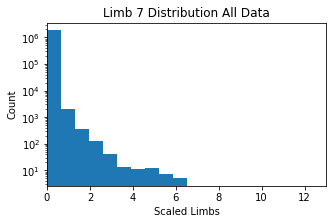

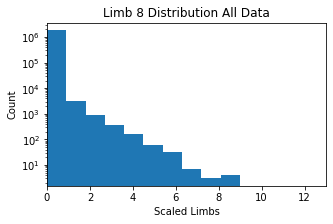

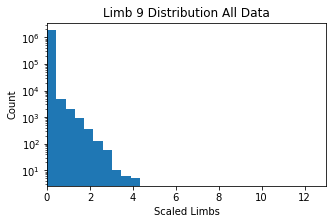

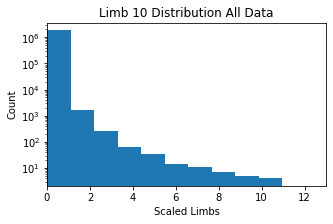

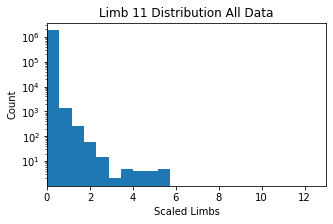

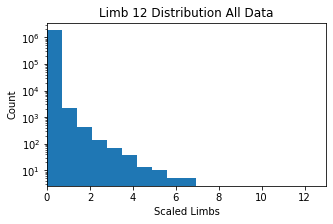

In [85]:
# Scaled Limbs All Data
num_fr, num_limbs = scaled_limbs.shape
for i in range(num_limbs):
    fig, ax = plt.subplots(figsize=(5,3))
    ax.hist(scaled_limbs[:,i], log=True)
    ax.set(xlabel="Scaled Limbs", ylabel="Count", title=f"Limb {i} Distribution All Data", xlim=[0,13])
    plt.show()

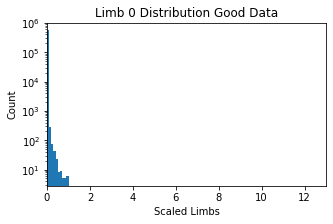

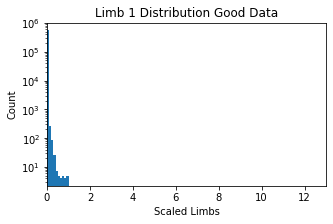

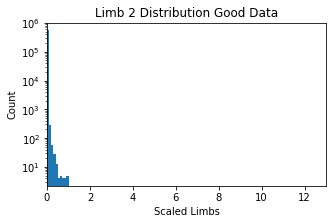

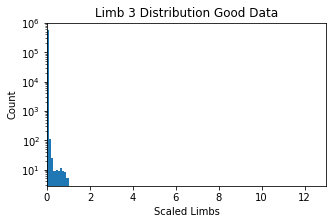

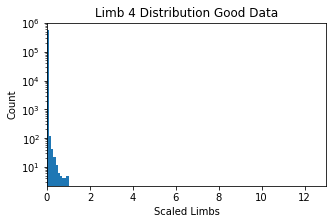

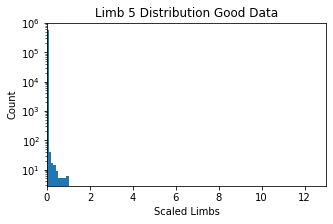

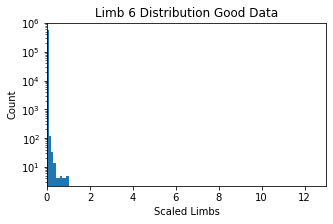

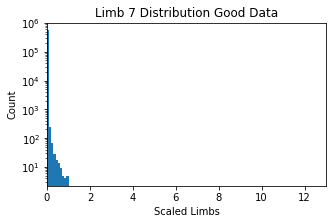

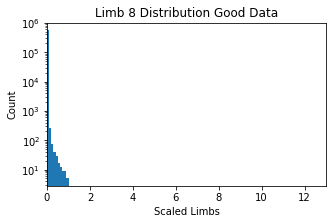

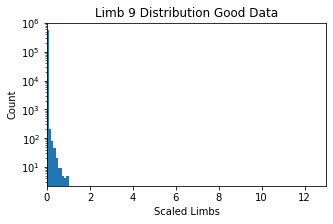

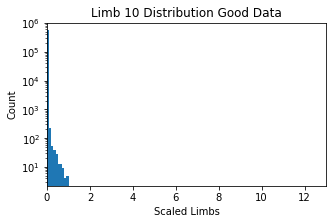

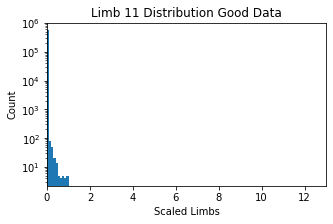

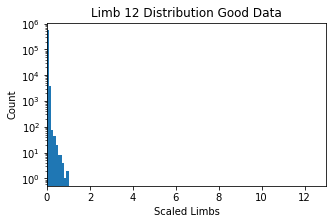

In [86]:
# Scaled Limbs Good Data
num_fr, num_limbs = scaled_limbs.shape
for i in range(num_limbs):
    fig, ax = plt.subplots(figsize=(5,3))
    ax.hist(scaled_limbs[tot_good_fr,i], log=True)
    ax.set(xlabel="Scaled Limbs", ylabel="Count", title=f"Limb {i} Distribution Good Data", xlim=[0,13])
    plt.show()

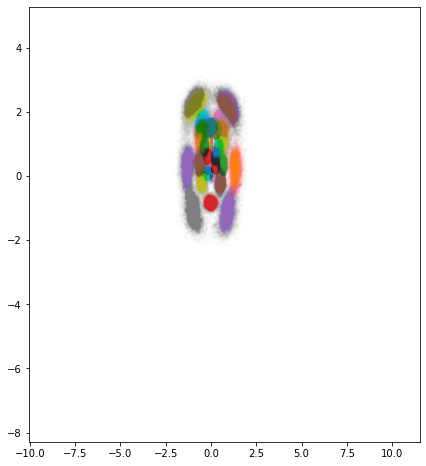

In [82]:
# Do all good rames have good limb length?
from sklearn.utils import shuffle 

rand_good_fr = shuffle(tot_good_fr)
rand_good_fr = rand_good_fr[:10000]

# fr=100
bounds=[-3,3,-3,4.5]

fig, ax = plt.subplots(figsize=(7,8))
for bp_i in range(30):
    ax.scatter(rot_bp[rand_good_fr,bp_i,0], rot_bp[rand_good_fr,bp_i,1], s=7, alpha=0.005)
# # plot skeleton
# if (skeleton is not None) and (skeleton_color is not None):
#     for skeleton_i, color_i in zip(skeleton, skeleton_color):
#         ax.plot(rot_bp[fr,skeleton_i,0], rot_bp[fr,skeleton_i,1], alpha=0.7, c=color_i, linewidth=2)
# ax.set(title=f"Ant Model Bodypoints for Frame {fr}",
#     xlabel="scaled x coord", ylabel="scaled y coord")
# if bounds is not None:
#     ax.set(xlim=[bounds[0],bounds[1]] , ylim=[bounds[2],bounds[3]])
plt.show()

In [114]:
num_fr = len(all_embed)
nan_fr, nan_dim = np.where(np.isnan(all_embed))
nan_fr = np.unique(nan_fr)
non_nan_fr = np.array([True]*num_fr)
non_nan_fr[nan_fr] = False

In [118]:
# Angle Magnitude
print( np.round(np.max(scaled_angles[non_nan_fr], axis=0), 2) )
print( np.round(np.max(angle_power[non_nan_fr], axis=(0,1)), 2) )

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[4.77 5.06 3.21 2.61 2.33 2.28 3.1  2.22 2.14 2.35 3.15 1.65]


In [117]:
# Limb Magnitude
print( np.round(np.max(scaled_limbs[non_nan_fr], axis=0), 2) )
print( np.round(np.max(limb_power[non_nan_fr], axis=(0,1)), 2) )

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[18.83 26.37 27.09 32.66 34.5  77.14 63.13 41.28 23.42 21.92 25.62 59.25
 30.53]


<hr><hr>

In [123]:
# Understand why Morlet Powerspectrogram Magnitude is so high
from helper import  morlet
# Morlet on Angle and Limb Features
INFO_items = list(INFO.items())
for key, file in tqdm(INFO_items):
    save_path = file['directory']
    bp = np.load(f"{PROJECT_PATH}/{save_path}/bodypoints.npy")
    angles = np.load(f"{PROJECT_PATH}/{save_path}/angles.npy")
    limbs = np.load(f"{PROJECT_PATH}/{save_path}/limbs.npy")

    # Joint Angle
    stand_angles = angle_scaler.transform(angles) - angle_scaler.scaled_means_ # scale
    angle_power = morlet(config, stand_angles)
    print(np.round(np.max(angle_power, axis=(0,1)), 2))

    # Limb Length
    stand_limbs = limb_scaler.transform(limbs) - limb_scaler.scaled_means_  # scale
    limb_power = morlet(config, limbs)
    print(np.round(np.max(limb_power, axis=(0,1)), 2))
    
    good_fr, bad_fr, disregard_fr = locate_bad_fr(config, bp)
    
    break

[3.63 2.56 1.93 2.34 1.92 2.58 1.47 2.39 1.93 1.6  2.45 1.83]
[16.12  4.03  5.13 23.81 10.99  8.71 12.56 23.27 28.5  26.06 14.08 25.53
  7.25]



In [127]:
# Angle Magnitude
print( np.round(np.max(stand_angles, axis=0), 2) )
print( np.round(np.max(angle_power, axis=(0,1)), 2) )

print( np.round(np.max(stand_angles[good_fr], axis=0)  + angle_scaler.scaled_means_, 2) )
print( np.round(np.max(angle_power[good_fr], axis=(0,1)), 2) )

[0.95 1.09 0.59 0.29 0.69 0.83 0.12 0.38 0.68 0.26 0.13 0.61]
[3.63 2.56 1.93 2.34 1.92 2.58 1.47 2.39 1.93 1.6  2.45 1.83]
[0.99 1.   0.58 0.86 0.47 0.22 0.68 0.67 0.44 0.8  0.9  0.47]
[1.73 1.74 0.34 0.22 0.31 0.18 0.19 0.24 0.23 0.28 0.21 0.18]


In [128]:
# Limb Magnitude
print( np.round(np.max(stand_limbs, axis=0), 2) )
print( np.round(np.max(limb_power, axis=(0,1)), 2) )

print( np.round(np.max(stand_limbs[good_fr], axis=0), 2) )
print( np.round(np.max(limb_power[good_fr], axis=(0,1)) + limb_scaler.scaled_means_ , 2) )

[0.67 0.02 0.1  0.58 0.27 0.09 0.49 0.54 1.2  1.15 0.47 0.43 0.21]
[16.12  4.03  5.13 23.81 10.99  8.71 12.56 23.27 28.5  26.06 14.08 25.53
  7.25]
[0.04 0.02 0.01 0.01 0.03 0.01 0.02 0.03 0.04 0.02 0.03 0.   0.04]
[0.52 0.5  0.47 0.55 0.8  0.77 0.74 0.99 0.75 0.48 0.97 0.54 1.61]


In [129]:
np.argmax(stand_limbs, axis=0)

array([1066,  279, 1066, 1066, 1066, 1066, 1178, 1066, 1066, 1066, 1066,
       1066, 1066])

In [130]:
np.argmax(limb_power, axis=0)

array([[1062,  819, 1069, 1060, 1062, 1064, 1175, 1059, 1060, 1060, 1064,
        1060, 1063],
       [1061,  819, 1068, 1060, 1063, 1063, 1176, 1059, 1060, 1060, 1064,
        1061, 1062],
       [1060,  443, 1063, 1060, 1062, 1061, 1174, 1059, 1061, 1061, 1063,
        1061, 1062],
       [1061,  439, 1058, 1062, 1063, 1062, 1175, 1061, 1063, 1063, 1065,
        1062, 1063],
       [1062,  436, 1056, 1063, 1064, 1062, 1175, 1062, 1064, 1064, 1065,
        1063, 1062],
       [1065,  433,  441, 1066, 1065, 1064, 1176, 1063, 1065, 1065, 1067,
        1064, 1061],
       [1069,  123, 1068, 1069, 1068, 1067, 1178, 1067, 1067, 1067, 1069,
        1067, 1063],
       [1068,  124, 1068, 1068, 1067, 1067, 1181, 1068, 1067, 1067, 1069,
        1067, 1064],
       [1067,  134, 1066, 1067, 1067, 1067, 1185, 1069, 1067, 1067, 1070,
        1068, 1067],
       [1066,  585, 1065, 1066, 1066, 1066, 1183, 1068, 1066, 1066, 1069,
        1067, 1067],
       [1067,  423, 1067, 1067, 1067, 1067, 1181, 